# Insurance Modeling with TabPFN and LightGBM

This notebook explores how TabPFN stacks up against LightGBM for predicting insurance claim costs using the Kangaroo dataset. The dataset comes from a past Travelers Insurance competition focused on modeling claim costs from auto policies.

TabPFN is a transformer-based model designed for tabular data, offering quick, parameter-free predictions, especially on small to mid-sized datasets. LightGBM, a popular gradient boosting framework, is currently the reigning king for classification and regression with structured data.

## TabPFN Implementation Approaches

### Basic TabPFN
The base TabPFN model processes tabular data using a pre-trained transformer architecture:
- Stores training data during fit() without traditional model training
- During prediction, combines stored training data with test data in a single forward pass
- Uses in-context learning to understand patterns, similar to how language models process text
- Makes predictions without hyperparameter tuning
- Can use batching and data permutations to improve robustness

### AutoTabPFN Ensemble
TabPFN offers two key approaches to ensembling:

1. **AutoTabPFN** (implemented here)
  - Automatically creates an ensemble of TabPFN models
  - Varies sampling strategies and batch sizes
  - Optimizes the combination of models within a specified time budget
  - Handles the complexity of ensemble creation internally
  - Available through the `tabpfn-community` package

2. **Manual Multi-Model Ensembling** (alternative approach)
  - Combines TabPFN with different model types (e.g., LightGBM, CatBoost)
  - Leverages TabPFN's unique error patterns - it makes different types of mistakes than traditional models
  - Requires manual tuning of model weights and combination strategies

We use AutoTabPFN to evaluate TabPFN's standalone performance and capabilities. This allows us to assess the model's effectiveness without conflating its results with those of traditional approaches. The `max_time` parameter controls how long AutoTabPFN spends searching for optimal ensemble configurations.

Key implementation details:
- One-hot encoding for categorical features
- Batch prediction to manage memory usage
- Zero floor for predictions (appropriate for insurance losses)
- GPU acceleration when available

## TabPFN Mathematical Framework

TabPFN is based on Bayesian principles and implements what's called a "Prior-Data Fitted Network" (PFN). Here's a breakdown of how it works.

### What is In-Context Learning?
In-context learning allows a model to learn from examples "on the fly" during prediction, without updating its weights. When making a prediction, TabPFN looks at the training examples you provide and uses its pre-trained attention mechanisms to identify relevant patterns. This is similar to how GPT models can solve math problems by looking at a few examples, even though they weren't explicitly trained on math - they learned the general ability to recognize and apply patterns from examples.

### 1. Prior Definition

The model starts with a sophisticated prior distribution over possible data-generating mechanisms:

- Combines both Structural Causal Models (SCMs) and Bayesian Neural Networks (BNNs)
- Assigns higher prior probability to simpler mechanisms (following Occam's Razor)
- Encodes domain knowledge about typical tabular data relationships

### 2. Posterior Predictive Distribution (PPD)

The fundamental mathematical operation TabPFN approximates is computing the Posterior Predictive Distribution:

p(y|x, D) ∝ ∫ p(y|x, φ)p(D|φ)p(φ)dφ

Where:
- x is the test point to predict
- D is the provided training data
- φ represents possible data-generating mechanisms
- p(φ) is the prior probability of mechanism φ
- p(D|φ) is the likelihood of training data under mechanism φ
- p(y|x, φ) is the prediction for y given x under mechanism φ

### 3. Training Process

Rather than training on user data, TabPFN is pre-trained on synthetic datasets:

1. Generate many synthetic datasets from the prior distribution
2. Train the transformer to approximate the PPD computation
3. Learn to perform Bayesian inference without MCMC or variational methods
4. Store the learned approximation in transformer weights

### 4. Prediction Mechanism

At prediction time, TabPFN:

1. Takes in both training examples and test points
2. Uses transformer attention to:
   - Compare test points to training examples
   - Weight different possible data-generating mechanisms
   - Approximate the PPD integration
3. Outputs predictions in a single forward pass

### 5. Key Mathematical Benefits

This approach offers several advantages:

1. **Efficiency**: Avoids expensive MCMC sampling or variational optimization
2. **Flexibility**: Prior can encode various assumptions about data generation
3. **Uncertainty**: Natural handling of uncertainty through Bayesian framework
4. **Simplicity**: No hyperparameter tuning needed at inference time

This mathematical foundation explains TabPFN's ability to make predictions without traditional training - it has already learned to perform approximate Bayesian inference for a broad class of data-generating mechanisms.

## Environment set up

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, d2_tweedie_score
from sklearn.preprocessing import OneHotEncoder
import optuna
from tabpfn import TabPFNRegressor
from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import (
    AutoTabPFNRegressor
)
import torch
import torch.nn.utils.prune as prune

c:\Users\carol\.virtualenvs\tabPFN_insurance_modeling-ExIrKSQR\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Datasets
Load the datasets from the data/ folder into pandas DataFrames.

In [2]:
# Load Datasets
train_df = pd.read_csv('data/Kangaroo_train.csv')
test_df = pd.read_csv('data/Kangaroo_valid.csv')

# Display the first few rows of the train dataset
train_df.head()

,id,veh_value,exposure,veh_body,veh_age,gender,area,dr_age,claim_ind,claim_count,claim_cost
0,3,6.43,0.241898,STNWG,1,M,A,3,0,0,0.0
1,6,4.46,0.856523,STNWG,1,M,A,3,0,0,0.0
2,20,1.70,0.417517,HBACK,1,M,A,4,0,0,0.0
3,21,0.48,0.626975,SEDAN,4,F,A,6,0,0,0.0
4,28,1.96,0.089770,HBACK,1,F,A,2,0,0,0.0


Display basic information about the train dataset, such as its shape, column names, and data types:

In [3]:
# Display Summary Statistics
print("\n## Train Dataset Summary Statistics:")
print(train_df.describe())

# Check for Missing Values
print("\n## Missing Values in Train Dataset:")
print(train_df.isnull().sum())

# Display Basic Information for Test Dataset
print("\n## Test Dataset Info:")
print(test_df.info())
print("\n## Test Dataset Head:")
print(test_df.head())

# Display Summary Statistics for Test Dataset
print("\n## Test Dataset Summary Statistics:")
print(test_df.describe())

# Check for Missing Values in Test Dataset
print("\n## Missing Values in Test Dataset:")
print(test_df.isnull().sum())


## Train Dataset Summary Statistics:
                 id     veh_value      exposure       veh_age        dr_age  \
count  22610.000000  22610.000000  22610.000000  22610.000000  22610.000000   
mean   33893.220920      1.866813      0.477853      2.676382      3.488147   
std    19593.196269      1.283358      0.284605      1.067311      1.426596   
min        3.000000      0.000000      0.002767      1.000000      1.000000   
25%    17020.250000      1.060000      0.232867      2.000000      2.000000   
50%    33789.500000      1.570000      0.455127      3.000000      3.000000   
75%    50928.000000      2.250000      0.712574      4.000000      5.000000   
max    67852.000000     25.600000      0.999338      4.000000      6.000000   

          claim_ind   claim_count    claim_cost  
count  22610.000000  22610.000000  22610.000000  
mean       0.067846      0.072004    140.007568  
std        0.251487      0.274595   1123.338125  
min        0.000000      0.000000      0.000000  


Proportion of zero values in 'claim_cost': 93.22%

Summary Statistics for 'claim_cost':
count    22610.000000
mean       140.007568
std       1123.338125
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      57895.584560
Name: claim_cost, dtype: float64


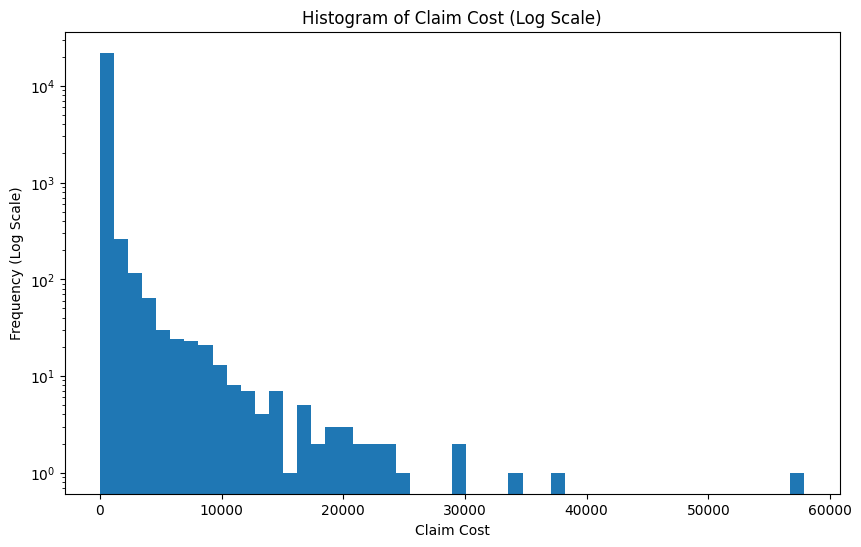

In [4]:
# Calculate and display the proportion of zero values
zero_proportion = (train_df['claim_cost'] == 0).mean()
print(f"Proportion of zero values in 'claim_cost': {zero_proportion:.2%}")

# Display summary statistics
print("\nSummary Statistics for 'claim_cost':")
print(train_df['claim_cost'].describe())

# Plot histogram with logarithmic scale
plt.figure(figsize=(10, 6))
plt.hist(train_df['claim_cost'], bins=50, log=True)
plt.title('Histogram of Claim Cost (Log Scale)')
plt.xlabel('Claim Cost')
plt.ylabel('Frequency (Log Scale)')
plt.show()

## Construct loss per exposure

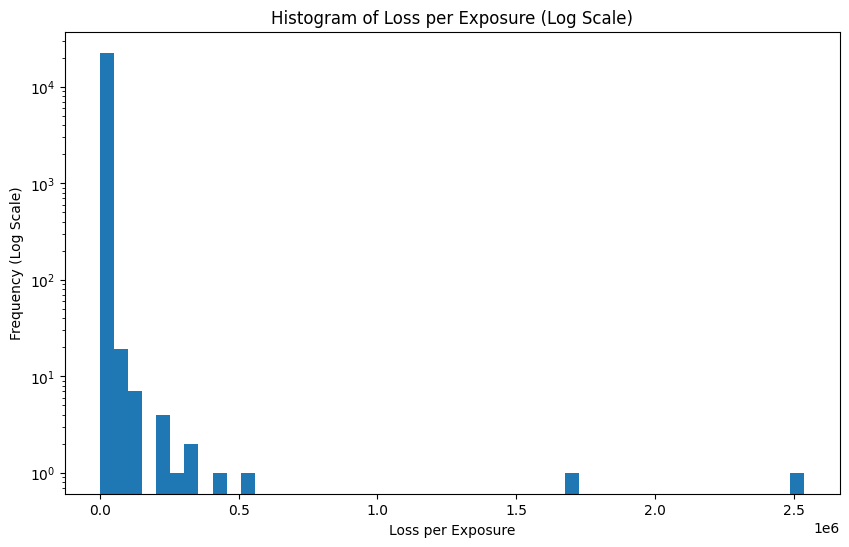

In [5]:
# Calculate Loss per Exposure
train_df['loss_per_exposure'] = train_df['claim_cost'] / train_df['exposure']
test_df['loss_per_exposure'] = test_df['claim_cost'] / test_df['exposure']

# Plot histogram of Loss per Exposure
plt.figure(figsize=(10, 6))
plt.hist(train_df['loss_per_exposure'], bins=50, log=True)
plt.title('Histogram of Loss per Exposure (Log Scale)')
plt.xlabel('Loss per Exposure')
plt.ylabel('Frequency (Log Scale)')
plt.show()

## Baseline model: LightGBM

In [6]:
# Prepare the Data
categorical_features = ['veh_body', 'gender', 'area']
features = train_df.drop(columns=['claim_cost', 'claim_count', 'claim_ind'\
    , 'loss_per_exposure', 'id'])
target = train_df['loss_per_exposure']
weights = train_df['exposure']

# Prepare the Validation Data
X_valid = test_df.drop(columns=['claim_cost', 'claim_count', 'claim_ind', 'loss_per_exposure', 'id'])
y_valid = test_df['loss_per_exposure']
w_valid = test_df['exposure']

# Convert categorical features to 'category' dtype
for col in categorical_features:
    features[col] = features[col].astype('category')
    X_valid[col] = X_valid[col].astype('category')

In [7]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.model_selection")


In [8]:

# Define the Objective Function for Optuna
def objective(trial):
    params = {
        'objective': 'tweedie',
        'tweedie_variance_power': trial.suggest_float('tweedie_variance_power', 1.1, 1.9),
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 50),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 50),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'verbose': -1
    }

    # Create LightGBM Dataset
    lgb_data = lgb.Dataset(
        features, 
        label=target, 
        weight=weights, 
        categorical_feature=categorical_features, 
        free_raw_data=False
    )

    # Perform Cross-Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = lgb.cv(
        params,
        lgb_data,
        num_boost_round=1000,
        folds=kf,
        stratified=False,
        metrics='rmse'
    )

    # Extract the Best Number of Boosting Rounds
    best_num_boost_round = len(cv_results['valid rmse-mean'])

    # Train the Final Model
    bst = lgb.train(
        params,
        lgb_data,
        num_boost_round=best_num_boost_round
    )

    # Predict on the Validation Set
    y_pred = bst.predict(X_valid, num_iteration=bst.best_iteration)

    # Evaluate the Model
    d2_score = d2_tweedie_score(y_valid, y_pred, power=params['tweedie_variance_power'])
    return d2_score

# Create an Optuna Study and Optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)


# Print the Best Hyperparameters
print(f"Best Hyperparameters: {study.best_params}")


[I 2025-02-13 09:18:02,078] A new study created in memory with name: no-name-69a188a8-ff6f-416b-bf25-b89177681965
C:\Users\carol\AppData\Local\Temp\ipykernel_14844\2735669469.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
[I 2025-02-13 09:18:15,104] Trial 0 finished with value: -0.17911413878064275 and parameters: {'tweedie_variance_power': 1.1276749095986534, 'learning_rate': 0.013663127658604767, 'num_leaves': 49, 'min_data_in_leaf': 36, 'feature_fraction': 0.7253896953581642, 'bagging_fraction': 0.9922262085985663, 'bagging_freq': 2}. Best is trial 0 with value: -0.17911413878064275.
C:\Users\carol\AppData\Local\Temp\ipykernel_14844\2735669469.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

Best Hyperparameters: {'tweedie_variance_power': 1.1577751139062422, 'learning_rate': 0.010057343040589473, 'num_leaves': 20, 'min_data_in_leaf': 17, 'feature_fraction': 0.8837236082267461, 'bagging_fraction': 0.9674300613569107, 'bagging_freq': 4}


In [10]:
# Train the Final Model with the Best Hyperparameters
best_params = study.best_params
best_params['objective'] = 'tweedie'
best_params['metric'] = 'rmse'
best_params['boosting_type'] = 'gbdt'
best_params['verbose'] = -1

# Create LightGBM Dataset
lgb_data = lgb.Dataset(features, label=target, weight=weights)

# Perform Cross-Validation with the Best Hyperparameters
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = lgb.cv(
    best_params,
    lgb_data,
    num_boost_round=1000,
    folds=kf,
    callbacks=[lgb.early_stopping(50)]  # FIX: early stopping is now inside callbacks
)

# Extract the Best Number of Boosting Rounds
best_num_boost_round = len(cv_results['valid rmse-mean'])  # Ensure correct metric key
print(f"Best number of boosting rounds: {best_num_boost_round}")

# Train the Final Model
bst = lgb.train(
    best_params,
    lgb_data,
    num_boost_round=best_num_boost_round
)

# Predict on the Validation Set
y_pred = bst.predict(X_valid, num_iteration=bst.best_iteration)

# Evaluate the Model
rmse = mean_squared_error(y_valid, y_pred) ** 0.5
d2_score = d2_tweedie_score(y_valid, y_pred, power=best_params['tweedie_variance_power'])

print(f"RMSE: {rmse:.4f}")
print(f"Tweedie D2 Score: {d2_score:.4f}")

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[80]	cv_agg's valid rmse: 3804.18 + 897.931
Best number of boosting rounds: 80
RMSE: 5196.8137
Tweedie D2 Score: -0.0116


## TabPFN model

### Single model

In [11]:
# confirm CUDA is available
if torch.cuda.is_available():
    num_devices = torch.cuda.device_count()
    print(f"Number of available CUDA devices: {num_devices}")
    for i in range(num_devices):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available.")

Number of available CUDA devices: 1
Device 0: NVIDIA GeForce RTX 3070 Ti Laptop GPU


In [12]:
# Limit precision to save memory
torch.set_default_dtype(torch.float16)  

# Limit GPU memory usage to 80% to avoid OOM errors
torch.cuda.set_per_process_memory_fraction(0.8, torch.device('cuda:0'))

In [ ]:
# Sample data
sample_size = min(10000, len(features))
sample_indices = np.random.choice(len(features), size=sample_size, replace=False)
X_sampled = features.iloc[sample_indices]
y_sampled = target.iloc[sample_indices]

In [ ]:
# Get index positions of categorical features to use in TabPFN
categorical_indices = [features.columns.get_loc(col) for col in categorical_features]

In [ ]:
# Fit model
model = TabPFNRegressor(device="cuda:0", \
        categorical_feature_indeces=categorical_indices, \
        random_state=42)
model.fit(X_sampled, y_sampled)

c:\Users\carol\.virtualenvs\tabPFN_insurance_modeling-ExIrKSQR\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\carol\.virtualenvs\tabPFN_insurance_modeling-ExIrKSQR\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carol\.virtualenvs\tabPFN_insurance_modeling-ExIrKSQR\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


TabPFNRegressor(device='cuda:0')

In [ ]:
# Define batch size for prediction (adjust based on GPU memory)
batch_size = 512  # Try smaller values if OOM persists

# Function to split data into batches to reduce memory load
def batch_predict(model, X, batch_size):
    predictions = []
    for i in range(0, len(X), batch_size):
        batch = X[i : i + batch_size]
        pred = model.predict(batch)
        predictions.append(pred)
    return np.concatenate(predictions, axis=0)

# Run batched predictions
y_pred = batch_predict(model, X_valid, batch_size=batch_size)

# Set a floor of 0 for negative predictions
y_pred = np.where(y_pred < 0, 0, y_pred)

c:\Users\carol\.virtualenvs\tabPFN_insurance_modeling-ExIrKSQR\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\carol\.virtualenvs\tabPFN_insurance_modeling-ExIrKSQR\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carol\.virtualenvs\tabPFN_insurance_modeling-ExIrKSQR\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\carol\.virtualenvs\tabPFN_insurance_modeling-ExIrKSQR\Lib\site-pack

In [20]:
# Evaluate the Model
rmse = mean_squared_error(y_valid, y_pred) ** 0.5  
d2_score = d2_tweedie_score(y_valid, y_pred, power=1.13) 

print(f"RMSE: {rmse:.4f}")
print(f"Tweedie D2 Score: {d2_score:.4f}")

RMSE: 5197.8949
Tweedie D2 Score: -0.0460


### Ensemble

In [ ]:
# Initialize and fit AutoTabPFN
model = AutoTabPFNRegressor(
    max_time=1200,  # 20 minutes tuning time
    device='cuda:0',  # Use GPU
    categorical_feature_indeces=categorical_indices,
    random_state=42
)
model.fit(X_sampled, y_sampled)

2025-02-13 09:59:55 INFO     Using `default` preset for Post Hoc Ensemble.
2025-02-13 09:59:55 INFO     No categorical_feature_indices given. Assuming no categorical features.
c:\Users\carol\.virtualenvs\tabPFN_insurance_modeling-ExIrKSQR\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\carol\.virtualenvs\tabPFN_insurance_modeling-ExIrKSQR\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-02-13 09:59:55 INFO     Using task type: TaskType.REGRESSION
2025-02-13 09:59:55 INFO     Obtaining TabPFN models from a random portfolio.
2025-02-13 09:59:59 INFO     Using 100 base models: ['default_tabpfn_model_0', 'random_tabpfn_model_1', 'random_rf_pfn_model_2', 'random_tabpfn_model_3', 'random_rf_pfn_model_4', 'random_rf_pfn_model_5', 'ran

In [ ]:

# Predict in batches
def batch_predict(model, X, batch_size=512):
    predictions = []
    for i in range(0, len(X), batch_size):
        batch = X[i : i + batch_size]
        pred = model.predict(batch)
        predictions.append(pred)
    return np.concatenate(predictions, axis=0)

# Make predictions
y_pred = batch_predict(model, X_valid_encoded)

# Set floor at 0 for insurance predictions
y_pred = np.maximum(y_pred, 0)


In [ ]:

# Evaluate
rmse = mean_squared_error(y_valid, y_pred) ** 0.5
d2_score = d2_tweedie_score(y_valid, y_pred, power=1.13)
print(f"RMSE: {rmse:.4f}")
print(f"Tweedie D2 Score: {d2_score:.4f}")